#  Test

In this notebook a neural network is trained to learn to detect different classes of flowers.  
Instruction to reproduce this notebook:
- dowload the compressed dataset file from this link: https://www.robots.ox.ac.uk/~vgg/data/flowers/17/17flowers.tgz
- copy the file in your Google Drive inside a directory called BONES_TEST (see the variable 'data_path' for the exact path)
- uncomment the cell where the zip directories are exacted.

The dataset is composed of 17 different classes of flowers. For each classes you can find 80 pictures. This is a balanced dastased. The images are ordered by class. 

Example of image name: 'image_0828.jpg'.

Follows the list of the classes names with the corresponding index range (the number in the name) :

0 Daffodill      1/80

1 Snowdrop       81/160

2 Lilyvalley     161/240

3 Bluebell         241/320

4 Crocus       321/400

5 Iris       401/480

6 Tigerlily   481/560

7 Tulip  561/640

8 Fritillary    641/720

9 Sunflower   721/800

10 Daisy    801/880

11 Coltsfoot  881/960

12 Dandelion   961/1040

13 Cowslip  1041/1120

14 Buttercup  1121/1200

15 Windflower  1201/1280

16 Pansy 1281/1360


In [1]:
#mount your drive directory to access the data
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
from sklearn import metrics
import numpy as np
from matplotlib import pyplot as plt
import os
from warnings import filterwarnings
import tensorflow as tf
from tensorflow import io
from tensorflow import image
from tensorflow import keras
from tensorflow.keras import models 
from tensorflow.keras import layers
import tarfile
from sklearn.utils import shuffle
from numpy.lib.function_base import extract
from sklearn.model_selection import train_test_split

tf.get_logger().setLevel('ERROR')

#path variables, check if is different in your system
data_path = '/content/drive/MyDrive/BONES_TEST/'
zip_path = data_path + '17flowers.tgz'
dataset_dir = data_path + 'dataset'
image_path= dataset_dir + '/jpg/image_0828.jpg'

img_height = 180
img_width = 180
BATCHSIZE = 32


# check hardware acceleration
device_name = tf.test.gpu_device_name()
print('GPU: ', device_name)

GPU:  /device:GPU:0


In [3]:
#!UNCOMMENT THIS CELL IF THE DATASET WAS NOT EXTRACTED ALREADY!

#extract the dataset zip directory in the drive
 
# open file
#file = tarfile.open(zip_path)
# extracting file
#file.extractall(dataset_dir)
#file.close()


255


TensorShape([500, 538, 3])

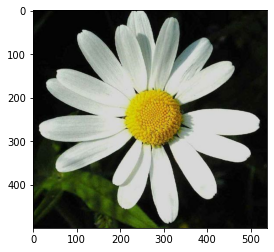

In [4]:
#show image example

filterwarnings("ignore") 
tf_img = io.read_file(image_path)
tf_img = image.decode_png(tf_img, channels=3)
print(np.amax(tf_img))
plt.imshow(tf_img)
tf_img.shape


In [5]:
#create class names list
class_names= ['Daffodil','Snowdrop','LilyValley','Bluebell','Crocus','Iris','Tigerlily','Tulip','Fritillary','Sunflower','Daisy', 'Colts foot','Dandelion','Cowslip', 'Buttercup','Windflower','Pansy']
class_size = len(class_names)

#create labels list
# x=[0]*N  list of size N, all N elements = 0.
labels = []
for i in range(17):
    labels += [i]*80

dataset_size=len(labels)

#create image paths list
filenames_path = dataset_dir + '/jpg/files.txt'
filenames = []
file = open(filenames_path, "r")
filenames = file.read().splitlines()  #each line without \n
file.close()
filenames = [ dataset_dir + '/jpg/' + s for s in filenames]

In [6]:
#shuffle in a consistent way the 2 lists
filenames,labels = shuffle(filenames, labels, random_state=0)
print(filenames[0], labels[0])

#extract test
x_train, x_test, y_train, y_test = train_test_split(filenames, labels, test_size=0.15, random_state=4, stratify=labels )
len(x_train),len(x_test) 

/content/drive/MyDrive/BONES_TEST/dataset/jpg/image_0894.jpg 11


(1156, 204)

In [7]:
#parse every image in the dataset using `map`
#retrieve the image, convert it to a tensor and resize it to fit the input layer of the model 180x180
def _parse_function(filename, label):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.cast(image_decoded, tf.float32) 
    image = tf.image.resize(image, [img_height, img_width])
    return image, label

In [8]:
#test dataset
filenames_test = tf.constant(x_test)
labels_test = tf.constant(y_test)

dataset_test = tf.data.Dataset.from_tensor_slices((filenames_test, labels_test))

dataset_test = dataset_test.map(_parse_function)
print(tf.data.experimental.cardinality(dataset_test).numpy())

204


In [9]:
#I dont use tf.keras.utils.image_dataset_from_directory (classes organized by directories needed), I create a tf.data.Dataset from a directory of images

filenames = tf.constant(x_train)
labels = tf.constant(y_train)

dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))

dataset = dataset.map(_parse_function)
 
dataset_size=tf.data.experimental.cardinality(dataset).numpy()

#create train test and validation set.            
val_size =  int((dataset_size) * 0.2)
train_ds = dataset.skip(val_size)
val_ds = train_ds.take(val_size)

print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

925
231


In [10]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)     
  ds = ds.batch(BATCHSIZE)      
  ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)  #allows later elements to be prepared while the current element is being processed  
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

The following is the architecture of the network, trained from scratch.

Since I was facing severe overfitting I added data augmentation layers, and a dropout layer to increase the performances.

In [11]:
model = models.Sequential()
model.add(tf.keras.Input(shape=(180,180,3)))

#Normalization layer
model.add(tf.keras.layers.Rescaling(1./255)),

#Data augmentation layers for overfitting
model.add(layers.experimental.preprocessing.RandomFlip(mode='horizontal', seed=123)) 
model.add(layers.experimental.preprocessing.RandomRotation(factor=0.25, seed=123, fill_mode='nearest')) #90degree

model.add(layers.Conv2D(32,(3,3),activation = 'relu' )) #32 filters 3x3, 3 channels    #num par= 3x3x3x32+32=896
model.add(layers.MaxPooling2D((2,2)))  #reduce activation map size by +-half, every 4 entries take 1  (2colums,2rows)
model.add(layers.Conv2D(64, (3,3), activation = 'relu' ))  #64 filters  3x3, 32 channels  #num par 3x3x32x64+64= 18496
model.add(layers.MaxPooling2D(2,2)) 
model.add(layers.Conv2D(128,(3,3), activation='relu'  )) #128 filters 3x3, 64 channels #num par 3x3x64x128+128=73856
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(128,(3,3), activation='relu' )) #128 filters 3x3, 128 channels #num par 3x3x128x128+128=147584
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Flatten())

#overfitting
model.add(layers.Dropout(0.4))

model.add(layers.Dense(512, activation='relu'))   
model.add(layers.Dense(17,activation='softmax'))  
model.summary()

#opt = keras.optimizers.RMSprop(learning_rate=0.001)    
opt = keras.optimizers.Adam() 

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),   
    optimizer=opt,    
    metrics=['accuracy']
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 180, 180, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 180, 180, 3)      0         
 tion)                                                           
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        1

In [12]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=24
)

Epoch 1/24
29/29 [==============================] - 24s 206ms/step - loss: 2.6236 - accuracy: 0.1124 - val_loss: 2.2546 - val_accuracy: 0.2468
Epoch 2/24
29/29 [==============================] - 3s 104ms/step - loss: 2.1277 - accuracy: 0.2659 - val_loss: 1.9092 - val_accuracy: 0.3117
Epoch 3/24
29/29 [==============================] - 3s 96ms/step - loss: 1.8807 - accuracy: 0.3578 - val_loss: 1.6646 - val_accuracy: 0.4156
Epoch 4/24
29/29 [==============================] - 3s 101ms/step - loss: 1.6364 - accuracy: 0.4227 - val_loss: 1.3428 - val_accuracy: 0.5671
Epoch 5/24
29/29 [==============================] - 4s 131ms/step - loss: 1.4266 - accuracy: 0.5038 - val_loss: 1.3245 - val_accuracy: 0.5411
Epoch 6/24
29/29 [==============================] - 3s 100ms/step - loss: 1.2909 - accuracy: 0.5643 - val_loss: 1.1398 - val_accuracy: 0.5887
Epoch 7/24
29/29 [==============================] - 3s 96ms/step - loss: 1.2801 - accuracy: 0.5654 - val_loss: 1.1780 - val_accuracy: 0.6320
Epoch 8

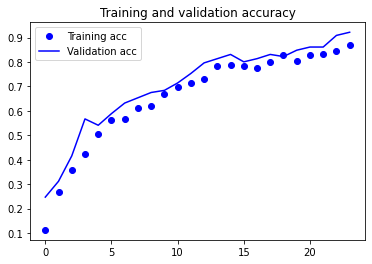

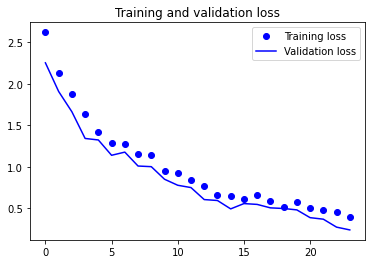

In [13]:
#print the plot of the loss and accuracy values during the various epochs of the training

import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [14]:
#example of single inference using a personal picture. save the pic in the Drive directory and add the filename in the following line
sunflower_path =  data_path + 'pic.jpg'

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
 
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
print(max(predictions[0]))

score = tf.nn.softmax(predictions[0])
print(score)
print(sum(score))
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 252ms/step
1.0
tf.Tensor(
[0.05342371 0.05342371 0.05342371 0.05342371 0.05342371 0.05342371
 0.05342371 0.05342371 0.05342371 0.14522068 0.05342371 0.05342371
 0.05342371 0.05342371 0.05342371 0.05342371 0.05342371], shape=(17,), dtype=float32)
tf.Tensor(0.99999994, shape=(), dtype=float32)
This image most likely belongs to Sunflower with a 14.52 percent confidence.


In [15]:
#nfere the test images using the trained model

dataset_test = dataset_test.batch(BATCHSIZE)  
test_pred = model.predict(dataset_test) 
predicted_labels = np.argmax(test_pred, axis=1)

test_labels = np.array(y_test)
test_predictions = np.squeeze(predicted_labels)

7/7 [==============================] - 1s 117ms/step


report:
               precision    recall  f1-score   support

           0       0.36      0.42      0.38        12
           1       0.82      0.75      0.78        12
           2       1.00      0.75      0.86        12
           3       0.73      0.67      0.70        12
           4       0.75      0.75      0.75        12
           5       0.90      0.75      0.82        12
           6       0.85      0.92      0.88        12
           7       0.33      0.25      0.29        12
           8       0.92      0.92      0.92        12
           9       0.80      1.00      0.89        12
          10       0.92      0.92      0.92        12
          11       0.44      0.67      0.53        12
          12       0.57      0.67      0.62        12
          13       0.62      0.67      0.64        12
          14       0.57      0.33      0.42        12
          15       1.00      0.83      0.91        12
          16       0.79      0.92      0.85        12

    accuracy     

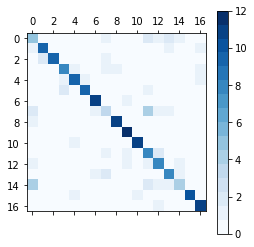

In [16]:
m = metrics.confusion_matrix(test_labels, test_predictions)

print( f'report:\n {metrics.classification_report(test_labels, test_predictions)}')
plt.matshow(m, cmap=plt.cm.get_cmap('Blues', 16))
plt.colorbar()
plt.show()